# RNN ile Hava yolu Yolcu Sayısı Tahmini
* İş problemi
* Veriyi anlamak
* Veriyi Hazırlamak
* Modelleme
* Değerlendirme

# İş Problemi
* Month : Aylık olan yer alan tarih değişkenidir.
* Passenger : İlgili işlem tarihindeki yolcu sayısını, yyani aylık yolcu sayısını temsil etmektedir.

In [6]:
## veriyi okuma ve işleme adımında kullanılacak olan kütphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
## Model değerlendirme ve veriyi scale edebilmek için ;
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#model için kullanılacak kütpahaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#warning..
import warnings
warnings.filterwarnings('ignore')

# Veriyi Anlamak

In [7]:
df = pd.read_csv('international-airline-passengers.csv')

In [8]:
df

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [23]:
df.isnull().value_counts()

Month  International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
False  False                                                                             144
       True                                                                                1
dtype: int64

In [24]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [25]:
df.columns =['Month', 'Passengers']

In [27]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [32]:
df.shape

(145, 2)

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [33]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [35]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

# Veriyi Hazırlama

In [37]:
df = df[:144]

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [39]:
df['Month'] = pd.to_datetime(df['Month'])

In [44]:
df.Month.min()

Timestamp('1949-01-01 00:00:00')

In [45]:
df.Month.max()

Timestamp('1960-12-01 00:00:00')

In [46]:
df.index =df.Month

In [47]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [48]:
df.drop(columns=['Month'], axis=1, inplace=True)

In [50]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


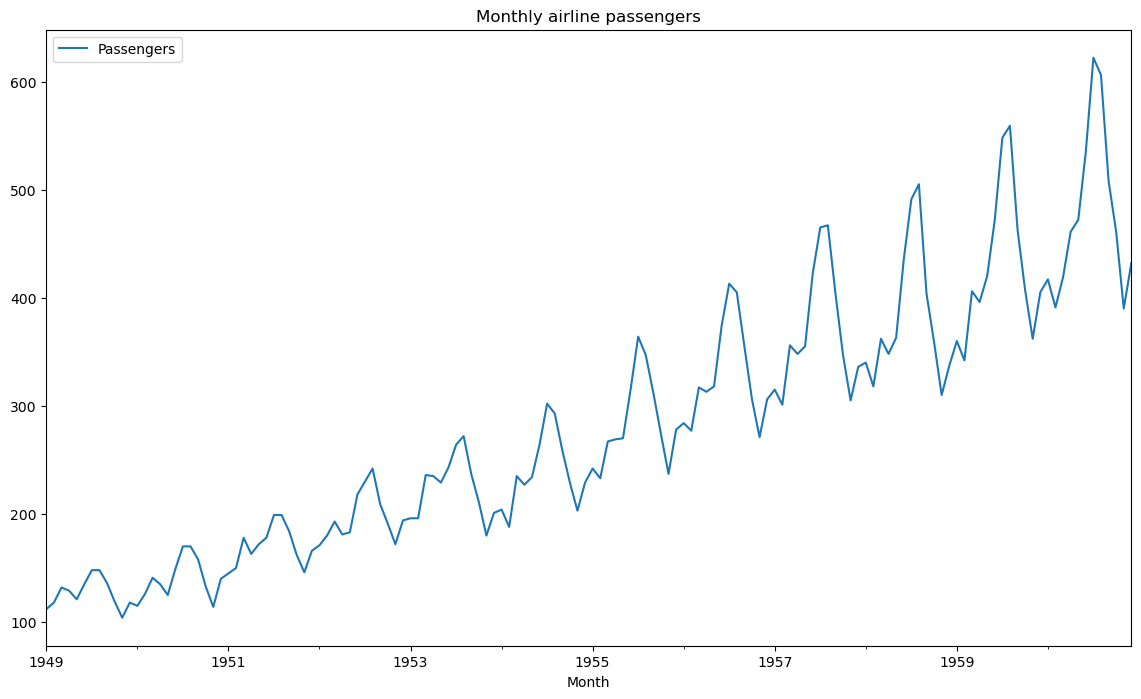

In [52]:
df.plot(figsize= (14,8), title = 'Monthly airline passengers');

In [60]:
data =df ['Passengers'].values

In [61]:
type(data[0:5])

numpy.ndarray

In [62]:
type(data[0])

numpy.float64

In [63]:
data = data.astype('float32')

In [64]:
type(data[0])

numpy.float32

In [65]:
data.shape

(144,)

In [66]:
data = data.reshape(-1,1)

In [67]:
data.shape

(144, 1)

In [68]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train,test,position

In [69]:
train, test, position = split_data(data,0.33)

In [70]:
train.shape , test.shape

((96, 1), (48, 1))

In [72]:
scaler_train = MinMaxScaler(feature_range=(0,1))

In [73]:
train = scaler_train.fit_transform(train)

In [74]:
scaler_test = MinMaxScaler(feature_range=(0,1))

In [75]:
test = scaler_test.fit_transform(test)

In [76]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [80]:
def create_features(data, lookback):
    X,Y = [],[]
    
    for i in range (lookback, len(data)):
        X.append(data[i-lookback: i,0])
        Y.append(data[i,0])
        
    return np.array(X),np.array(Y)

In [94]:
X_train, y_train = create_features(train, 1)

In [95]:
X_test, y_test = create_features(test, 1)

In [96]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [100]:
X_train.shape

(95, 1, 1)

In [101]:
y_train.shape

(95, 1)

# Modelleme

In [103]:
lookback= 1

In [107]:
model = Sequential()

model.add(SimpleRNN(units = 50, activation='relu',
                   input_shape=(X_train.shape[1], lookback)))


model.add(Dropout(0.2))

model.add(Dense(1))

In [110]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Optmizasyon ve değerlendirme metrikleri ayarlanması

In [111]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [112]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience=3, verbose = 1 , mode='min'),
            ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss', mode='min',
                           save_best_only=True, save_weights_only=False, verbose =1)            ]

In [115]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size = 1,
                    callbacks=callbacks,
                    validation_data = (X_test,y_test),
                    shuffle=False)

Epoch 1/50

89/95 [===========================>..] - ETA: 0s - loss: 0.0291
Epoch 1: val_loss improved from inf to 0.03363, saving model to mymodel.h5
95/95 [==============================] - 2s 6ms/step - loss: 0.0289 - val_loss: 0.0336
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.0241
Epoch 2: val_loss improved from 0.03363 to 0.02542, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0241 - val_loss: 0.0254
Epoch 3/50
94/95 [============================>.] - ETA: 0s - loss: 0.0174
Epoch 3: val_loss improved from 0.02542 to 0.02334, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0173 - val_loss: 0.0233
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 0.0146
Epoch 4: val_loss improved from 0.02334 to 0.02233, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0223
Epoch 5/50
91/95 [=====================

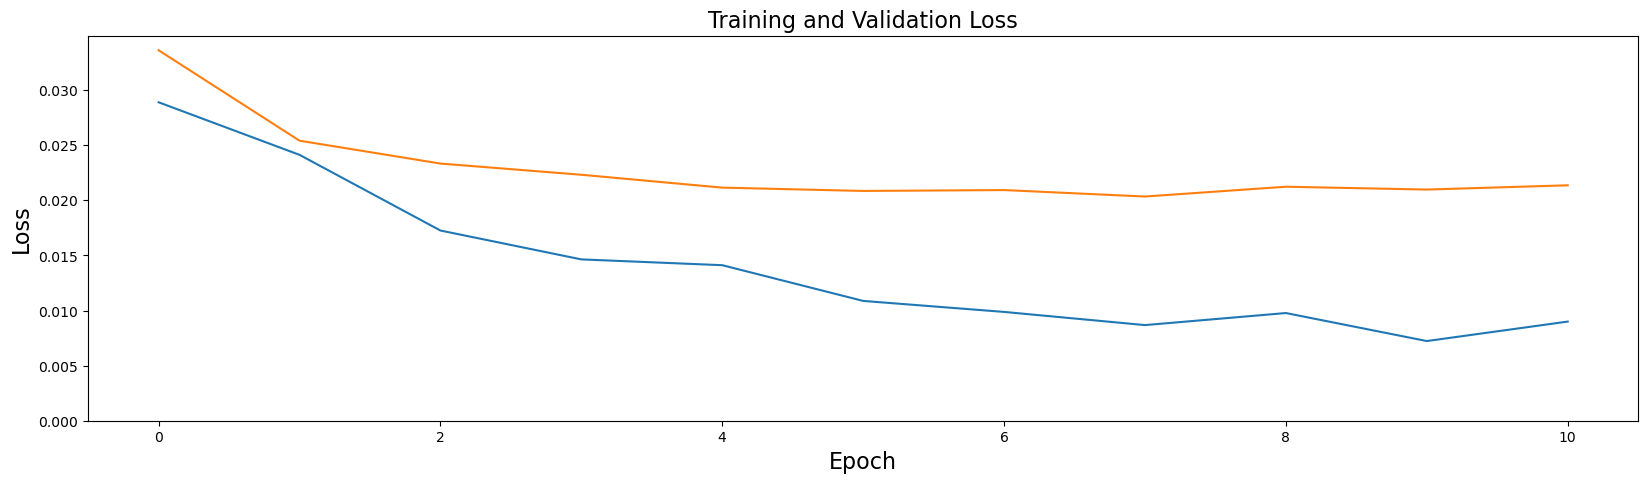

In [124]:
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'],label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize =16)
plt.show()

# Değerlendirme

In [163]:
loss = model.evaluate(X_test , y_test, batch_size =1)
print("\nTest loss: %.1f%%"% (100.0*loss))

47/47 [==============================] - 0s 1ms/step - loss: 0.0214

Test loss: 2.1%


In [164]:
train_predict = model.predict(X_train)

3/3 [==============================] - 0s 2ms/step


In [165]:
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


In [166]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [167]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [168]:
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [169]:
print(f'train : {train_rmse}' + f' test : {test_rmse}')

train : 23.71571159362793 test : 46.92396545410156


In [170]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [172]:
result_df = df.copy()

In [174]:
train_prediction_df = result_df[lookback: position]
train_prediction_df['Predicted'] = train_predict

In [176]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,131.367035
1949-03-01,132.0,134.731171
1949-04-01,129.0,146.014053
1949-05-01,121.0,143.248047
1949-06-01,135.0,136.810150


In [178]:
train_prediction_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,95.0,214.778947,71.526543,104.000000,160.000000,201.000000,265.500000,413.000000
Predicted,95.0,220.676392,65.684212,127.926254,166.298164,207.788391,267.718689,404.111847


In [179]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df['Predicted'] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,332.580811
1957-03-01,356.0,325.855438
1957-04-01,348.0,368.537201
1957-05-01,355.0,361.161224
1957-06-01,422.0,367.615265


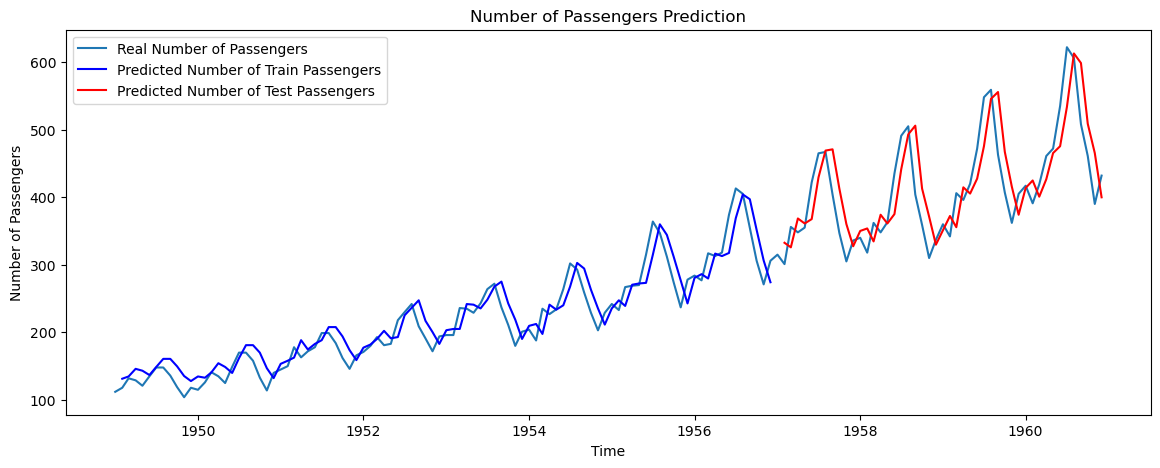

In [183]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label = 'Real Number of Passengers')
plt.plot(train_prediction_df['Predicted'],label = 'Predicted Number of Train Passengers', color='blue')
plt.plot(test_prediction_df['Predicted'],label = 'Predicted Number of Test Passengers', color='red')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()